In [1]:
%pylab inline
import naomi

Populating the interactive namespace from numpy and matplotlib


# IFM
The example commes from a IFM measured for NOAMI with HASO128 and the Alpao DM241. 
The dimension is (241, 128, 128) for the 128x128 phase screens of the 241 actuators. The amplitude is normalised by the command applied to the actuator.

Each image is an average of several push-pull images to remove any phase artifact due to the bench

In [47]:
ifm = naomi.load_ifm_example_dm241()

## Example of what loocks like an Influence function (for two actuator)  

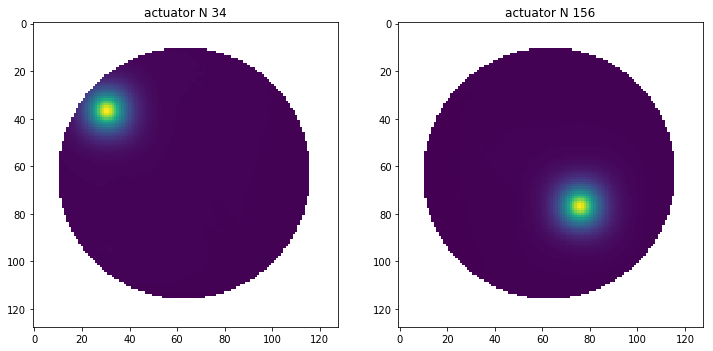

In [3]:
acts = [34, 156]

f, ax = subplots(1,len(acts))
f.set_size_inches((12,6))
def plot_if(ifm, ax, actuator):
    ax.imshow(ifm[actuator])
    ax.set_title( f'actuator N {actuator}')
for axes,a in zip(ax, acts):
    plot_if(ifm, axes, a)
    plot_if(ifm, axes, a)

## IF profile fitting
There is possibility to fit a profile to extract key caracteristics (amplitude, centering, FWHM, ...) 

In [4]:
fmt = 'Act {act} Influence function centered in {r.center[0]:.2f},{r.center[1]:.2f} pixel'
for a in acts:
    r= naomi.fit_if_profile(ifm[a])
    print(f'Act {a:3d} Influence function centered in {r.center[0]:.2f},{r.center[1]:.2f} pixel')

Act  34 Influence function centered in 30.56,36.58 pixel
Act 156 Influence function centered in 75.95,76.70 pixel


/Users/guieus/anaconda3/lib/python3.7/site-packages/naomi-0.1.2-py3.7.egg/naomi/compute/command.py:375: RuntimeWarning: invalid value encountered in less


One can see the fit model from the result 

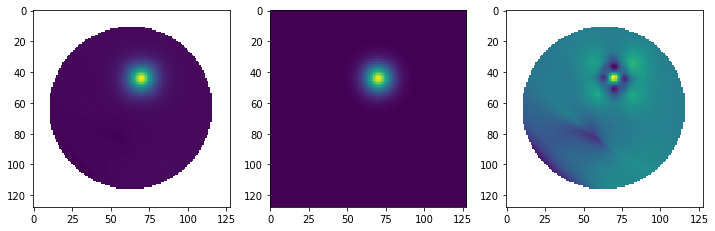

In [5]:
f, (ax_if, ax_model, ax_residual) = subplots(1,3)
f.set_size_inches((12,6))


r = naomi.fit_if_profile(ifm[134])
ax_if.imshow(ifm[134])
ax_model.imshow(r.img_model(ifm[134].shape))
_ = ax_residual.imshow(ifm[134]-r.img_model(ifm[134].shape))

---
## Measure mis-Alignment
Some usefull stuff. the Alignment class handle some "alignment" informations like the centering of the phase screen  and the phase screen pixel scale. 

Both can be computed from an IFM: the center from the IF of the centra actuator (if any) and the scale from the IFM and the physical actuator separation distance. 

Below an instance of a DM class (DM241 in this case) is needed. It contains the physical caracteristics of the DM such as the separation distance between actuators, centra actuators and actuator layout. 

In [6]:
dm = naomi.DM241()
align = naomi.Alignment.from_ifm(ifm, dm)
print(f' Center= x={align.center[0]:.3f},x={align.center[0]:.3f} Scale={align.scale[0]:.3e} m/pixel')

 Center= x=62.943,x=62.943 Scale=3.870e-04 m/pixel


---
## The pupil trace on the HASO 
From the Alignment on can build a `PupilInstance` The pupill instance is defined from a `Pupil` object :  

- The `Pupil` class define the physical characteristics of the pupil
- The `PupilInstance` define its foot print of the gien pupil on an image following some alignment parameters

For instance one can define a pupil as a `Disk` (the only Pupil defined so far as it is the only one used for Naomi, one can define other shape with Spiders, or a central hole etc...)  

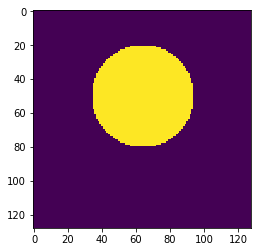

In [7]:
disk60pix = naomi.Disk( 60, 'pix') # a disk with 60 pixels diameter. unit in pixel avoid to have a system scale
pup = disk60pix.make([128,128],  [64,50])  # build the pupil foot print in a [128,128] image centered at pixel [64,50] 
_ = imshow( pup.mask  )

---
But a pupil can be instancied from an alignment class or directly from an IFM 

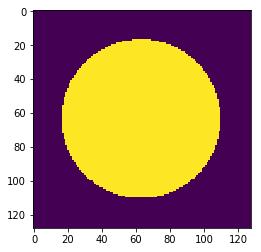

In [8]:
dm = naomi.DM241()
disk36mm = naomi.Disk( 36e-3, 'm') # A pupil of 36mm
pup = disk36mm.make_from_ifm(ifm,dm)
_ = imshow( pup.mask  )

---
This can be also done without IFM :

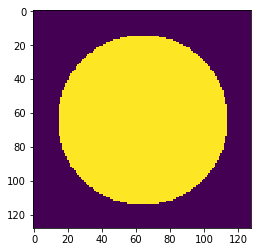

In [9]:
wfs = naomi.HASO128() # define some characteristics of the HASO128 Wave Front Sensor 
align = naomi.Alignment(center=[64,64], scale=0.00036)
imshow(naomi.Disk(36e-3, 'm').make_from_alignment(align, wfs).mask)

---
## ZtP Zernikes To Phase Matrix
Once a pupil is defined we can make some theoritical pure mode phase screens. For instance for zernike=2,3,4,5 tip, tilt, focus and astig

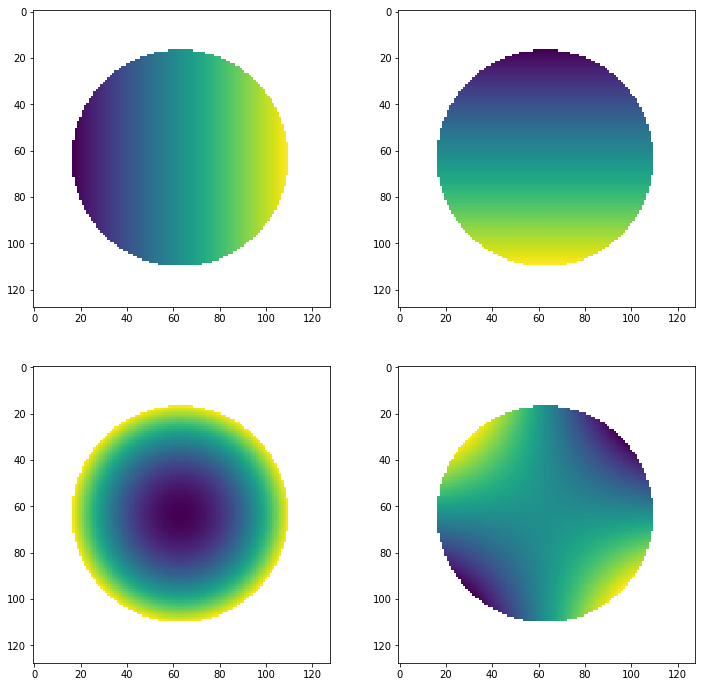

In [10]:
ztp = naomi.theoritical_phase([2,3,4,5], pup, invert=False)
f, axs = subplots(2,2)
f.set_size_inches(12,12)
for ax, z in zip(axs.flatten(), ztp):
    ax.imshow(z)


Modes are normalized to rms=1 : 

In [11]:
naomi.nanrms(ztp, axis=(1,2))

array([1., 1., 1., 1.])

---
## ZtC Zernike to Command matrix - "The Matrix"
The multiplication of the ZtP (Zernike to phase) matrix by the invert of the IFM is the Zernike to Command matrix used to change modal commands to local commands.

The `command_matrices` function allows to compute this command matrix from an IFM and a `pupil` and a list of zernikes. The function return 3 matrices : 

- ptc (Ny, Nx, Nact): Phase to command the invert of the IFM 
- ztc (Nzernike, Nact) : Zernike to command matrix 
- ztp (Nzernike, Ny, Nx) : Ther Zernike to phase matrix as computed by `naomi.theoritical_phase`

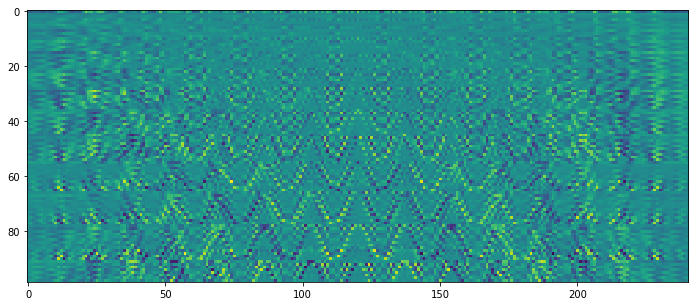

In [12]:
ptc, ztc, ztp = naomi.command_matrices(ifm, pup, range(1,100), nEigenValue=120, zeromean=True)
imshow(ztc)
plt.gcf().set_size_inches(18,5)

---
The ztc is what we need to convert zernikes amplitudes to a command. Let us plot the command applied to each actuators for a pure tilt : 

In [13]:
def z_to_c(zernikes, ztc):
    zamp = zeros(ztc.shape[:1])
    for num, amp in zernikes.items():
        zamp[num-1] = amp
    cmd = np.matmul(zamp, ztc) # the command vector is just a matrix multiplication
    return cmd
def plot_dm_cmd(cmd, vmin=None, vmax=None):            
    plt.axis('square') 
    scatter(dm.x, dm.y, s=100, c=cmd, vmin=vmin, vmax=vmax)
    # plot a circle showing the effective pupil on top of the DM layout 
    r, t = 36e-3/2., linspace(0, 2*pi, 50)
    plot(r*cos(t), r*sin(t), color='k')

    gca().set_xlim(-0.025, 0.025)
    gca().set_ylim(-0.025, 0.025)
    plt.colorbar()
    plt.gcf().set_size_inches(8, 8)

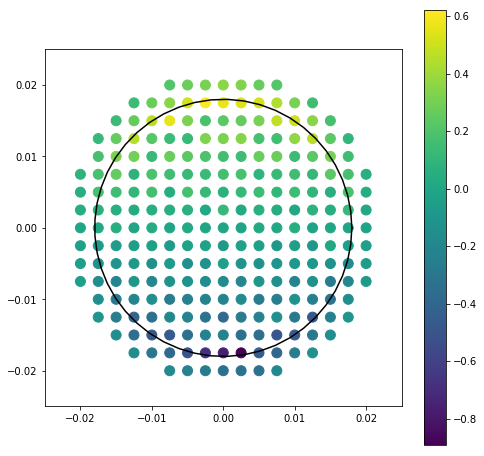

In [14]:
cmd = z_to_c({2:10}, ztc)
plot_dm_cmd( cmd ) # pur tip of 10.0 µm rms (this should be close to saturation)

---
Let us plot the profile of a vertical line of actuators. Note that the mean command is close to zero, this is an effect of the zeromean=True option in the `command_matrices` function. This is to avoid to put momentum on the DM and dump vibration. 

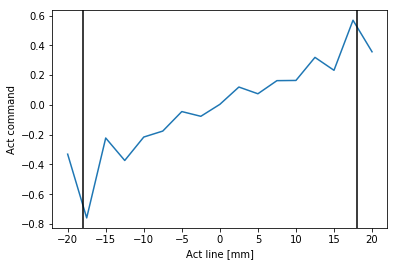

In [15]:
ou = where(dm.i==0)[0]
_ = plot( dm.y[ou]*1000, cmd[ou])
axvline(-36/2, color='k')
axvline( 36/2, color='k')
gca().set_xlabel('Act line [mm]'); _=gca().set_ylabel('Act command')

---
Other example : a bit of tip, focus, and astigmatism : 

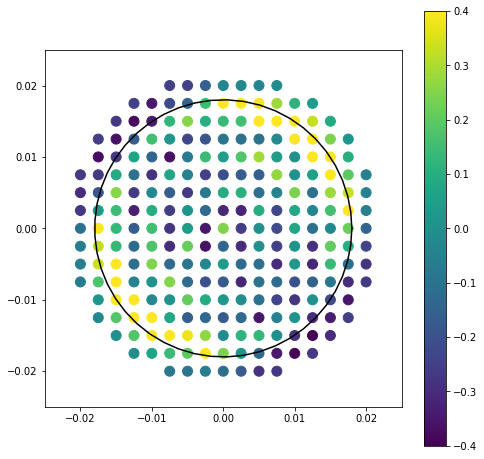

In [16]:
cmd_foc =  z_to_c({2:1.0, 4:4.0, 5:6.0}, ztc)
plot_dm_cmd(cmd_foc, vmax=0.4, vmin=-0.4 )

---
One can make a synthetic phase screen from DM commands this is just a matrix multiplication of the IFM and the command vector 

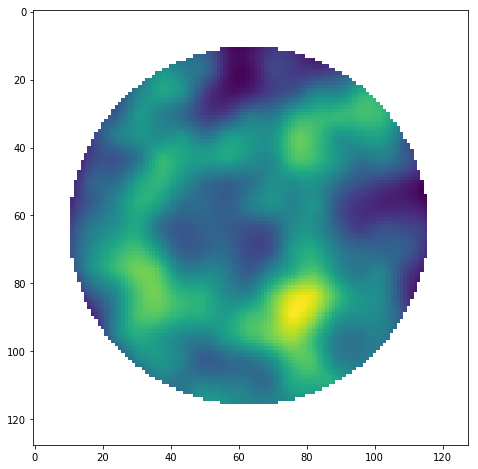

In [17]:
random_command = random.random(dm.i.shape)*0.01
_ = imshow(naomi.reconstruct_phase( random_command  , ifm   ))
gcf().set_size_inches(8,8)

---
Also to build a synthetic phase screen from zernikes we need the ztp as build above, example for a focus and a tip: 

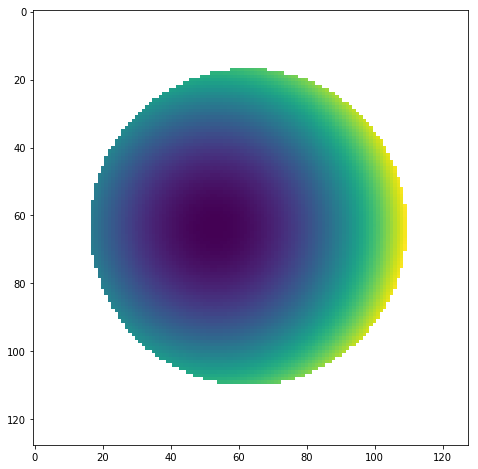

In [18]:
phase = naomi.phase_from_zernikes( [0.0, 3, 0.0, 4.0 ], ztp )
imshow(phase)
gcf().set_size_inches(8,8)

---
The reverse operation is to extract zernikes from a phase screen. First we compute (if not already computed) the ptz (phase to zernike) invert of the ztp. Than this is just a matrix multiplication of the phase screen by the ptz

In [19]:
ztp, ptz = naomi.theoritical_phase(range(1,14), pup, invert=True)
naomi.zernike_vector(phase, ptz) # see above ptz is the invert of the ztp Zernike to Phase matrix

array([-1.12757026e-17,  3.00000000e+00,  1.22124533e-15,  4.00000000e+00,
       -8.88178420e-16, -2.00360561e-16, -6.66133815e-16,  6.81746326e-16,
        1.55431223e-15,  9.54097912e-16,  3.18668703e-15, -7.35522754e-16,
        1.49880108e-15])

---
Let us do it all, for fun  : 

- compute a ztc zernike to command matrix 
- compute the command vector from a vector of zernikes and ztc
- reconstruct a synthetic phase screen from the commands 
- extract zernikes from the reconstructed phase

array([ 1.05661940e-02,  6.29803105e-04,  3.09922091e+00,  4.67834965e-03,
        4.19692770e+00,  1.19959310e-03, -2.24619872e-03])

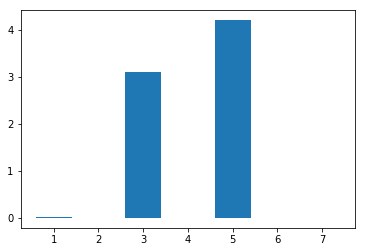

In [41]:
dm = naomi.DM241()
disk = naomi.Disk( 36e-3, 'm').make_from_ifm(ifm, dm)
ptc, ztc, ztp, ptz = naomi.command_matrices(ifm, 
                                            disk, range(1,100), 
                                            nEigenValue=120, zeromean=True, 
                                            invertztp=True
                                           )
zamp = np.zeros(ztc.shape[:1])
zamp[[2,4]] = [3.1,4.2]
cmd = np.matmul(zamp, ztc)
phase = naomi.reconstruct_phase(cmd, ifm)
zamp2 = naomi.zernike_vector(phase, ptz)
plt.bar(range(1,8),zamp2[:7])
zamp2[:7]

---
We can check the residuals between the reconstructed phase and a pure theoric phase screens

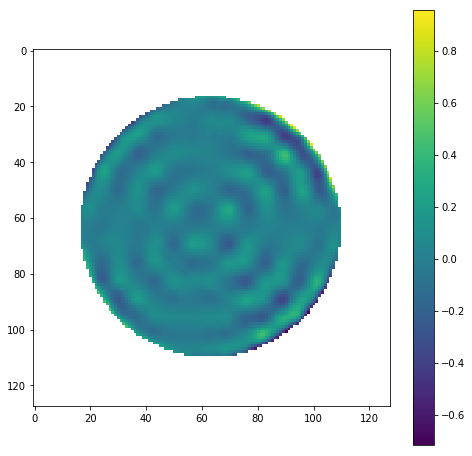

In [42]:
theoritical_phase = naomi.phase_from_zernikes(zamp, ztp)
imshow( phase-theoritical_phase)
colorbar()
gcf().set_size_inches(8,8)

---
For fun, the IF plotted in an actuator mosaic :

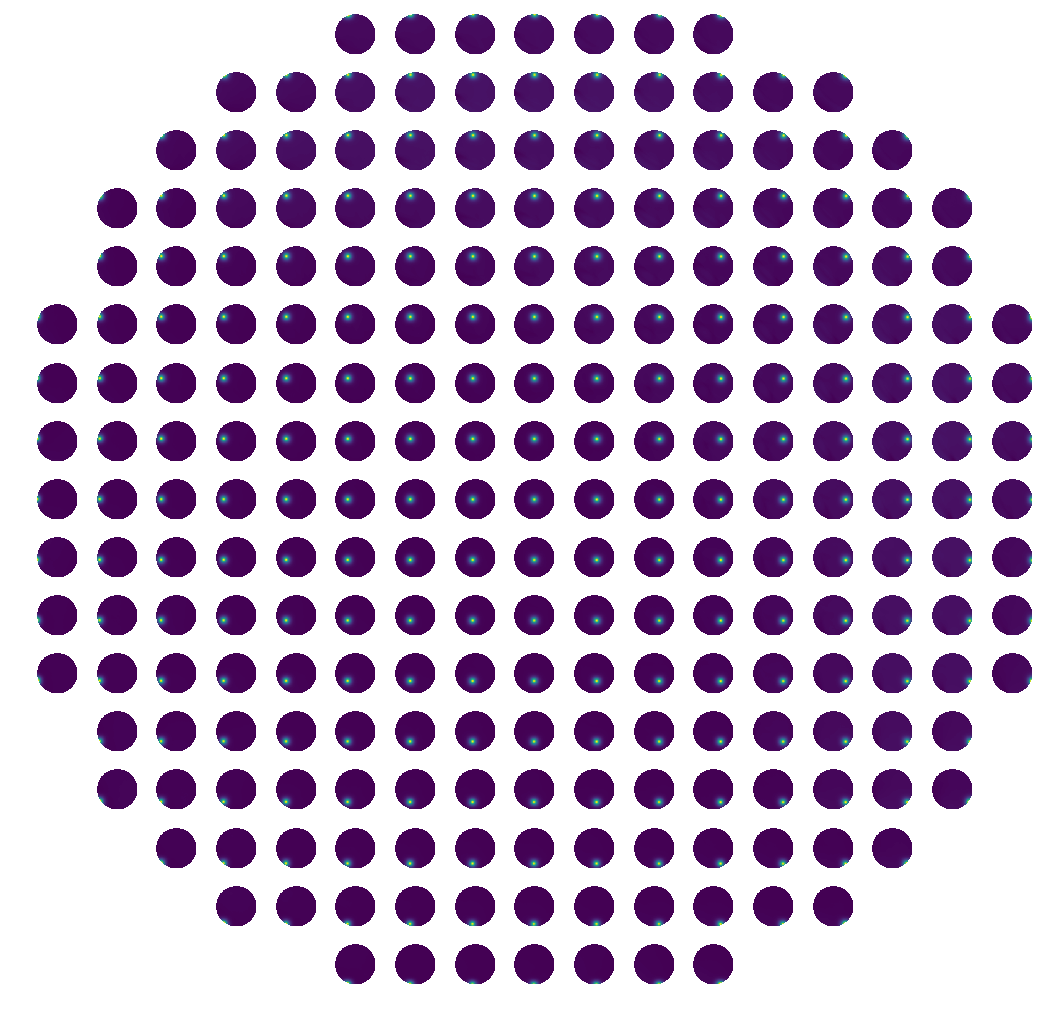

In [44]:
f, axs = subplots(17,17)
for ax in axs.flatten():
    ax.axis('off')
for if_, i, j in zip( ifm, dm.i, dm.j):
    axs[i+8,j+8].imshow(if_)
f.set_size_inches(18,18)

---
We can plot the position of each IF max center as measured in the IFM 

(3.297865749914502, 123.11055868962899, 3.3649836111302083, 123.1776765508447)

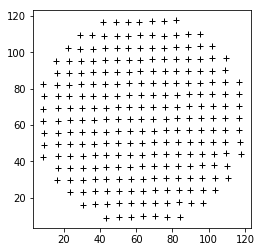

In [46]:
results = [naomi.fit_if_profile(if_) for if_ in ifm]
centers= array([r.center for r in results])
plot(*centers.T, '+k')
_ = gca().axis('square')